In [2]:
from google.colab import files
files.upload()

Saving model_Kuzushiji.h5 to model_Kuzushiji.h5


In [0]:
from PIL import ImageFont,Image,ImageDraw
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import load_model
%matplotlib inline

In [4]:
#Upgraded the kaggle API as my Kaggle API was not up to date.
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v


Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.3.1)
     |████████████████████████████████| 61kB 4.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=aecbcec669ada93a44d2d47c051010dd65979d7af17f481c63d8b30499e57528
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [6]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c kuzushiji-recognition

Saving kaggle.json to kaggle.json
100% 4.18G/4.19G [01:20<00:00, 54.8MB/s]
100% 4.19G/4.19G [01:20<00:00, 56.1MB/s]


In [7]:
!unzip kuzushiji-recognition
!mkdir data
!mkdir data/train_imgs/
!mkdir data/test_imgs/
!unzip train_images -d data/train_imgs/
!unzip test_images -d data/test_imgs/

Archive:  kuzushiji-recognition.zip
  inflating: sample_submission.csv   
  inflating: test_images.zip         
  inflating: train.csv               
  inflating: train_images.zip        
  inflating: unicode_translation.csv  
Archive:  train_images.zip
  inflating: data/train_imgs/200021660-00082_1.jpg  
  inflating: data/train_imgs/200004148_00039_2.jpg  
  inflating: data/train_imgs/200021853-00006_2.jpg  
  inflating: data/train_imgs/umgy008-020.jpg  
  inflating: data/train_imgs/hnsd012-017.jpg  
  inflating: data/train_imgs/hnsd004-021.jpg  
  inflating: data/train_imgs/hnsd007-024.jpg  
  inflating: data/train_imgs/100249371_00028_1.jpg  
  inflating: data/train_imgs/umgy006-029.jpg  
  inflating: data/train_imgs/200021802-00017_1.jpg  
  inflating: data/train_imgs/100249376_00051_1.jpg  
  inflating: data/train_imgs/200021712-00008_1.jpg  
  inflating: data/train_imgs/hnsd009-027.jpg  
  inflating: data/train_imgs/200021660-00049_1.jpg  
  inflating: data/train_imgs/200022050-0

In [8]:
#Downloading Japanese Noto Sans font to visualise japanese unicode digits.
# From https://www.google.com/get/noto/
!wget -q --show-progress https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip
!unzip -p NotoSansCJKjp-hinted.zip NotoSansCJKjp-Regular.otf > NotoSansCJKjp-Regular.otf
!rm NotoSansCJKjp-hinted.zip

font = ImageFont.truetype('./NotoSansCJKjp-Regular.otf', 50, encoding='utf-8')

NotoSansCJKjp-hinte 100%[===================>] 115.49M  47.8MB/s    in 2.4s    


In [15]:
train_df=pd.read_csv('/content/train.csv')
#Creating dictionary that maps unicode to actual characters.
unicode_map = {codepoint: char for codepoint, char in pd.read_csv('unicode_translation.csv').values}

#Cropping digit from page and creating digit image and label pair.
data=[]
tar=[]
for img_n,label in (train_df[:420].values):
  labels=np.array(label.split(' ')).reshape(-1,5) # Resizing into n x 5 array as the label is encoded as (image,x,y,width,height)
  img=cv2.imread('data/train_imgs/'+img_n+'.jpg') 
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  
  for uc,x,y,w,h in labels:
    x, y, w, h =int(x),int(y),int(w),int(h)
    char_img=img[y:y+h, x:x+w] #Crops the image using the coordinates provided in the labels.
    
    
    char_img=cv2.resize(char_img,(300,300)) #Resizing the image to 300 x 300
    char_img=np.asarray(char_img)
    char_img=cv2.cvtColor(char_img,cv2.COLOR_RGB2GRAY)
    ret,th1 = cv2.threshold(char_img,155,255,cv2.THRESH_BINARY_INV) #Applying binary inversion thresholding to have more sharp edges to detect.
    data.append(th1)
    tar.append(str(unicode_map[uc])) #Converting the unicode to real character.
print(np.array(data).shape)
print(np.array(tar).shape)

(51840, 300, 300)
(51840,)


In [0]:
#Seperately calling Label enocoder so that it can be used to remap the predicted integer labels to its string value(real label).
lb=LabelEncoder()
y_map=lb.fit_transform(tar)

In [0]:
#Lets now create a function which predicts all the characters on the image and also creates visualization.
def VisualiseCharacter(imgpath):
  img=cv2.imread(imgpath)
  imsource = Image.open(imgpath)
  char_draw = ImageDraw.Draw(imsource)
  im_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  ret, im_th = cv2.threshold(im_grey, 130, 255, cv2.THRESH_BINARY_INV)
  ctrs,_ = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #Detects the contours of the charcters which can be used to crop the image to be detected.
  rects = [cv2.boundingRect(ctr) for ctr in ctrs] #The function cv2.boundingRect returns the approx bounting box around the detected contour.
  Kuzushijis = []
  for rect in rects:
        leng = int(rect[3] * 1.6) #Calculating the length of character.
        pt1 = int(rect[1] + rect[3]//2 - leng// 2)
        pt2 = int(rect[0] + rect[2]//2 - leng// 2)
        roi = im_th[pt1:pt1+leng, pt2:pt2+leng] #Getting the region of interest where char is present which will be passed to the preprocessing function and then to model.
        if roi.size>7000:
            cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (225, 0, 0), 6) #Creating bounding boxes around the contours obtained.
            roi = cv2.resize(roi, (300,300)) #Resizing the roi to 300 x 300 as the model was trained to predict on 300 x 300 size image.
            #roi = cv2.dilate(roi, (3, 3))
            ret,th1 = cv2.threshold(roi,155,255,cv2.THRESH_BINARY) #Thresholding again.
            ProcessImage = th1.reshape(1,300, 300, 1) 
            y_pred = ku_model.predict(ProcessImage) #Getting probability distribution of the characters
            y_true = np.argmax(y_pred,axis=1) #The character the max probability is the predicted character.
            Kuzushiji = lb.inverse_transform(y_true) #Transforming the integre value to original character name using label encoder.
           
            Kuzushijis.append(str(Kuzushiji[0]))
            char_draw.text((rect[0]+10, rect[1]),str(Kuzushiji[0]), fill=(0,22,225,0), font=font) #Drawing Kuzushiji charactrers on page between the columns.
            #cv2.putText(img, str(Kuzushiji[0]), (rect[0], rect[1]),font, 2, (0, 255, 255), 3)
  return img,imsource


In [12]:
#Load the model
ku_model=load_model('model_Kuzushiji.h5')













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




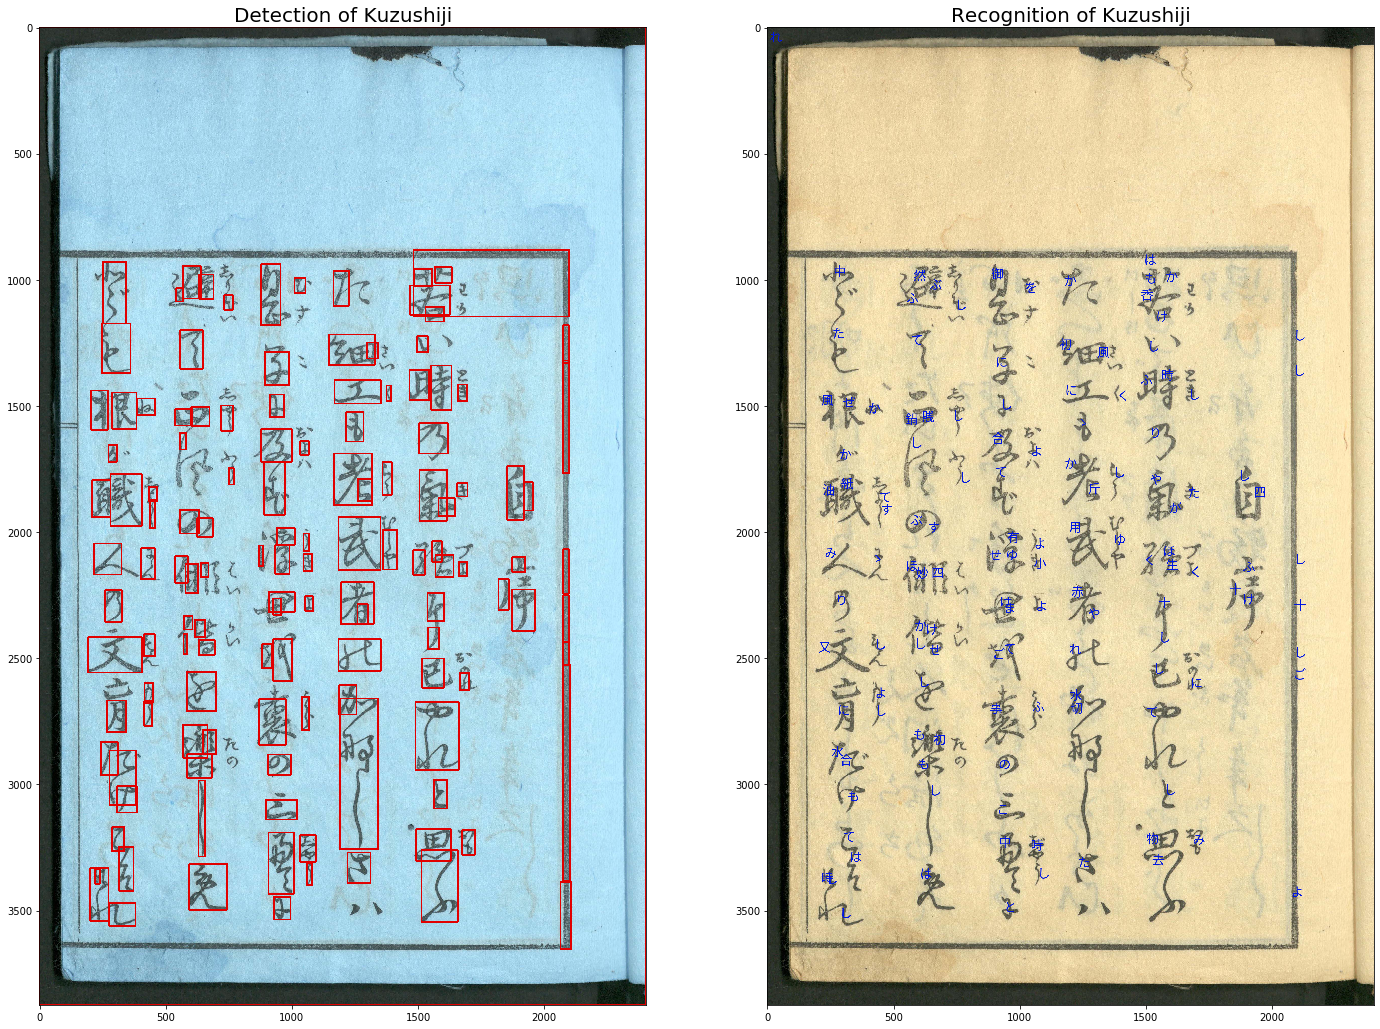

In [18]:
#Lets test it on image an visualize the image.
img1, imsource1 = VisualiseCharacter('data/train_imgs/100241706_00004_2.jpg')
plt.figure(figsize=(50,50))
plt.subplot(1,4,1)
plt.title("Detection of Kuzushiji",fontsize=20)
plt.imshow(img1)
plt.subplot(1,4,2)
plt.title("Recognition of Kuzushiji",fontsize=20)
plt.imshow(imsource1)